# Synthetic Data Generator

### Imports

In [1]:
import pandas as pd
import numpy as np
import networkx as nx
import arviz as az

import matplotlib.pyplot as plt

from scipy.stats import norm
from sklearn.linear_model import LinearRegression

import itertools
import random

import matplotlib.pyplot as plt
import seaborn as sns

from collections import defaultdict

from scipy.special import gamma
from scipy.special import gammaln

import xarray as xr


from scipy.linalg import block_diag

import pyAgrum as gum
import pyAgrum.lib.notebook as gnb

from pgmpy.models import BayesianModel, BayesianNetwork
from pgmpy.estimators import ParameterEstimator, BicScore

#from scipy.special import gammaln, multigammaln
from scipy.special import loggamma

from numpy.linalg import det, inv

from itertools import chain, combinations

from scipy.stats import invgamma, multivariate_normal

import gc

sns.set()

In [2]:

def compute_log_marginal_likelihood(df: pd.DataFrame, G: nx.DiGraph):
    n, _ = df.shape  

    # For sigma^2
    a0 = 1
    b0 = 1

    regularizer = 0.5
    
    total_log_ml = 0
    parameters = {}  # Dictionary to store the parameters for each node

    # Loop through each node in the graph
    for node in G.nodes():
        # Extract the data for the node
        y = df[node].values
        
        # If the node has parents
        if G.in_degree(node) > 0:
            # Extract the data for the node and its parents
            X = df[list(G.predecessors(node))].values
        else:
            # For root nodes, X is just an intercept term
            X = np.ones((len(y), 1))
        
        # If the node is not a root node, add the intercept term
        if G.in_degree(node) > 0:
            X = np.concatenate((np.ones((X.shape[0],1)), X), axis=1)
            
        p_node = X.shape[1]     # Number of predictors for this node + intercept
        # Setting up the Priors for beta
        Lambda0 = np.eye(p_node)*0.1   # Prior precision matrix
        m0 = np.zeros(p_node)       # Prior mean vector
        
        # Bayesian Linear Regression
        # Compute the posterior precision matrix Lambda_n for beta
        Lambda_n = Lambda0 + X.T @ X

        # Compute the posterior mean m_n for beta
        # if the matrix is singular, then this will give an error
        # so, we need to add regularization techniques to avoid this
        beta_hat = np.linalg.inv(X.T @ X) @ X.T @ y
        #beta_hat = np.linalg.inv(X.T @ X + regularizer * np.eye(X.shape[1])) @ X.T @ y
                
        m_n = np.linalg.inv(Lambda_n) @ (X.T @ X @ beta_hat + Lambda0 @ m0)


        # Compute a_n and b_n for sigma^2
        a_n = a0 + n/2
        b_n = b0 + 0.5 * (y.T @ y + m0.T @ Lambda0 @ m0 - m_n.T @ Lambda_n @ m_n)
        
        # Save the parameters for the node
        parameters[node] = {
            'Lambda_n': Lambda_n,
            'm_n': m_n,
            'a_n': a_n,
            'b_n': b_n,
            'y.T @ y': y.T @ y,
            'm0 dot lambda0 dot m0': m0 @ Lambda0 @ m0,
            'm_n.T dot Lambda_n dot m_n': m_n.T @ Lambda_n @ m_n,
            'X.T @ X' : X.T @ X
        }

        # Compute the Marginal Likelihood for this node and add to total
        log_ml_node = ( - (len(y)/2) * np.log(2*np.pi) 
                        + 0.5 * (np.linalg.slogdet(Lambda0)[1] - np.linalg.slogdet(Lambda_n)[1]) 
                        + a0 * np.log(b0) - a_n * np.log(b_n) + gammaln(a_n) - gammaln(a0) )
        total_log_ml += log_ml_node
    
    return total_log_ml, parameters



def compute_marginal_likelihood(df: pd.DataFrame, G: nx.DiGraph):
    marg, params = compute_log_marginal_likelihood(df, G)
    return np.exp(marg), params


In [3]:

def sample_parameters(parameters):
    sampled_values = {}
    for node, param in parameters.items():
        # Sample sigma^2 from the inverse gamma distribution
        sigma2 = invgamma.rvs(a=param['a_n'], scale=  param['b_n'])
        
        # Sample beta from the multivariate normal distribution
        cov_matrix = sigma2 * np.linalg.inv(param['Lambda_n'])
        beta = multivariate_normal.rvs(mean=param['m_n'], cov=cov_matrix)

        sampled_values[node] = {
            'beta': beta,
            'sigma2': sigma2
        }

    return sampled_values




In [3]:
def log_likelihood_bn(df, G):
    total_log_likelihood = 0.0
    
    # For each node in the graph
    for node in G.nodes():
        # Extract the data for the node
        y = df[node].values
        
        # If the node has parents (is not a root)
        if G.in_degree(node) > 0:
            # Extract the data for the node's parents
            X = df[list(G.predecessors(node))].values
            
            # Fit a linear regression model
            reg = LinearRegression().fit(X, y)
            
            # Compute the predicted values
            y_pred = reg.predict(X)
            
            # Compute the residuals
            residuals = y - y_pred
            
            # Compute the variance of residuals (our estimated sigma^2)
            sigma2 = np.var(residuals)
            
            # Compute the log likelihood for this node
            node_log_likelihood = (-0.5 * np.log(2 * np.pi * sigma2)) - (residuals**2 / (2 * sigma2))
            
            # Add to the total log likelihood
            total_log_likelihood += np.sum(node_log_likelihood)
            
        # If the node is a root, we assume a simple Gaussian likelihood
        else:
            mean = np.mean(y)
            sigma2 = np.var(y)
            
            root_log_likelihood = (-0.5 * np.log(2 * np.pi * sigma2)) - ((y - mean)**2 / (2 * sigma2))
            total_log_likelihood += np.sum(root_log_likelihood)
    
    return total_log_likelihood


In [4]:
def compute_parent_dict(graph):
    parent_dict = {}
    
    for node in graph.nodes():
        parent_dict[node] = list(graph.predecessors(node))
    return parent_dict

def possible_edges_for_dag(G, forbidden_list):
    possible_edges = []
    
    # Check all possible edges
    for u in G.nodes():
        for v in G.nodes():
            
            if u != v and not G.has_edge(u, v):
                # Temporarily add the edge
                G.add_edge(u, v)
                
                # Check for cycles using simple_cycles
                if any(nx.simple_cycles(G)):
                    G.remove_edge(u, v)  # Remove the edge if it causes a cycle
                else:
                    possible_edges.append((u, v))
                    G.remove_edge(u, v)  # Remove the edge to continue checking other possibilities

    return possible_edges



def propose_new_graph(G: nx.DiGraph, forbiddenArcs : list):
    # Create a deep copy of the graph to modify and return
    proposed_graph = G.copy()
    
    # List all the nodes
    nodes = list(G.nodes())
    
    # List all possible edges that could be added to the graph
    # only propose edges that do not violate the domain constraints
    possible_edges = possible_edges_for_dag(proposed_graph, forbiddenArcs)
    
    # delete the edges that violate the domain constraints
    for forbidden in forbiddenArcs:
        if forbidden in possible_edges:
            possible_edges.remove(forbidden)
    
    # Select an operation: add, remove, or reverse
    operations = ["add_edge", "delete_edge", "reverse_edge"]
    
    if len(G.edges()) == 0:  # If no edges, the only valid operation is "add"
        operation = "add_edge"
    elif len(possible_edges) == 0:  # If graph is fully connected, the only valid operation is "remove"
        operation = "delete_edge"
    else:
        operation = random.choice(operations)
    
    if operation == "add_edge":
        edge_to_add = random.choice(possible_edges)
        proposed_graph.add_edge(*edge_to_add)
    elif operation == "delete_edge":
        edge_to_remove = random.choice(list(G.edges()))
        proposed_graph.remove_edge(*edge_to_remove)
    else:  # reverse
        edge_to_reverse = random.choice(list(G.edges()))
        proposed_graph.remove_edge(*edge_to_reverse)
        proposed_graph.add_edge(edge_to_reverse[1], edge_to_reverse[0])
        
        # Check for cycles and revert the operation if a cycle is introduced
        if not nx.is_directed_acyclic_graph(proposed_graph):
            proposed_graph.remove_edge(edge_to_reverse[1], edge_to_reverse[0])
            proposed_graph.add_edge(*edge_to_reverse)
    
    # check if proposed graph is a dag
    if not nx.is_directed_acyclic_graph(proposed_graph):
        propose_new_graph(G, forbiddenArcs) # if it is not a dag, start over
        
    
    #print(f"G -> G' using {operation}")
    return proposed_graph, operation



def possible_add_edges(G : nx.DiGraph ):
    # Compute possible adds (all non-existing edges minus those that create cycles)
    possible_adds = 0
    for u in G.nodes():
        for v in G.nodes():
            if u != v and not G.has_edge(u, v):
                G.add_edge(u, v)
                if not nx.is_directed_acyclic_graph(G):
                    G.remove_edge(u, v)
                else:
                    possible_adds += 1
                    G.remove_edge(u, v)
    return possible_adds

def possible_remove_edges(G : nx.DiGraph ):
    # Compute possible removes (simply all existing edges)
    return len(G.edges())

def possible_reverse_edges(G : nx.DiGraph ):
    # Compute possible reverses (all edges whose reversal doesn't introduce a cycle)
    possible_reverses = 0
    edges_list = list(G.edges())
    for (u, v) in edges_list:
        G.remove_edge(u, v)
        G.add_edge(v, u)
        if nx.is_directed_acyclic_graph(G):
            possible_reverses += 1
        G.remove_edge(v, u)
        G.add_edge(u, v)
    return possible_reverses
    

# going from G -> G' with operation
def Q_G_to_G_prime(G, operation):
    
    possible_adds = possible_add_edges(G);
    possible_removes = possible_remove_edges(G);
    possible_reverses = possible_reverse_edges(G);
    
    nodes = G.nodes()
    total_possible_operations = len(nodes) * (len(nodes) - 1) #possible_adds + possible_removes + possible_reverses
    
    # if G -> G' is an add edge operation, then count how many add edges are possible
    if operation == "add_edge":
        #print(f"Possible adds: {possible_adds}\t Total possible operations: {total_possible_operations}")
        return possible_adds / total_possible_operations
    
    # if G -> G' is a remove edge operation, then count how many remove edges are possible
    if operation == "delete_edge":
        #print(f"Possible deletes: {possible_removes}\t Total possible operations: {total_possible_operations}")
        return possible_removes / total_possible_operations
    
    # if G -> G' is a reverse edge operation, then count how many reverse edges are possible
    if operation == "reverse_edge":
        #print(f"Possible reverses: {possible_reverses}\t Total possible operations: {total_possible_operations}")
        return possible_reverses / total_possible_operations
    
    return "Operation not found! You can only add_egde, remove_edge, or reverse_edge"

# going from G -> G' with operation
def Q_G_prime_to_G(G_prime, operation):
    
    possible_adds = possible_add_edges(G_prime);
    possible_removes = possible_remove_edges(G_prime);
    possible_reverses = possible_reverse_edges(G_prime);
    
    nodes = G_prime.nodes()
    total_possible_operations = len(nodes) * (len(nodes) - 1) #possible_adds + possible_removes + possible_reverses
    
    # if G -> G' is an add edge operation, then count how many remove edges are possible
    if operation == "add_edge":
        #print(f"Possible removes: {possible_removes}\t Total possible operations: {total_possible_operations}")
        return possible_removes / total_possible_operations
    
    # if G -> G' is a remove edge operation, then count how many remove edges are possible
    if operation == "delete_edge":
        #print(f"Possible adds: {possible_adds}\t Total possible operations: {total_possible_operations}")
        return possible_adds / total_possible_operations
    
    # if G -> G' is a reverse edge operation, then count how many reverse edges are possible
    if operation == "reverse_edge":
        #print(f"Possible reverses: {possible_reverses}\t Total possible operations: {total_possible_operations}")
        return possible_reverses / total_possible_operations
    
    return "Operation not found! You can only add_egde, remove_edge, or reverse_edge"
    
def compute_non_symmetric_acceptance_ratio(G_current, posterior_G_current, G_proposed, posterior_G_proposed, operation_G_to_G_prime ):

    # Compute the proposal distributions at the current and proposed graphs
    #print("Q(G|G')")
    Q_G_proposed_given_G = Q_G_to_G_prime(G_current, operation_G_to_G_prime)
    Q_G_given_G_proposed = Q_G_prime_to_G( G_proposed, operation_G_to_G_prime )

    return min(1, (posterior_G_proposed * Q_G_given_G_proposed) / (posterior_G_current * Q_G_proposed_given_G))


def compute_non_log_symmetric_acceptance_ratio(G_current, log_marginal_likelihood_G_current, G_proposed, log_marginal_likelihood_G_proposed, operation_G_to_G_prime ):
    
    Q_G_proposed_given_G = Q_G_to_G_prime( G_current, operation_G_to_G_prime )
    #print(f"Q(G|G') = {Q_G_proposed_given_G}") 
    Q_G_given_G_proposed = Q_G_prime_to_G( G_proposed, operation_G_to_G_prime )
    #print(f"Q(G'|G) = {Q_G_given_G_proposed}") 

    #print(f"P(G|D) = {log_marginal_likelihood_G_current}") 
    #print(f"P(G'|D) = {log_marginal_likelihood_G_proposed}") 
    log_numerator = log_marginal_likelihood_G_proposed + np.log(Q_G_given_G_proposed)
    log_denominator = log_marginal_likelihood_G_current + np.log(Q_G_proposed_given_G)
    
    #print( f"log_numerator = {log_numerator}" )
    #print( f"log_denominator = {log_denominator}" )
    #print( f"log_numerator - log_denominator = {log_numerator - log_denominator}" )
    log_alpha = log_numerator - log_denominator
    
    return min(0, log_alpha)

def compute_symmetric_acceptance_ratio(posterior_G_current, posterior_G_proposed):
    return min(1, posterior_G_proposed / posterior_G_current)

def compute_acceptance_ratio(G_current, posterior_G_current, G_proposed, posterior_G_proposed, operation, is_proposal_symmetric):
    
    if is_proposal_symmetric:
        # A(G, G') = min(1, P(G' | D) / P(G | D))
        A = compute_symmetric_acceptance_ratio(posterior_G_current, G_proposed, posterior_G_proposed)
    else:
        #  A(G, G') = min(1, [P(G' | D) * Q(G | G')] / [P(G | D) * Q(G' | G)])
        A =  compute_non_symmetric_acceptance_ratio(G_current, posterior_G_current, G_proposed, posterior_G_proposed, operation)
    return A


def compute_log_acceptance_ratio(G_current, log_marginal_likelihood_G_current, G_proposed, log_marginal_likelihood_G_proposed, operation, is_proposal_symmetric):
    
    if is_proposal_symmetric:
        # A(G, G') = min(0, logP(G' | D) / P(G | D))
        A = compute_log_symmetric_acceptance_ratio(log_marginal_likelihood_G_current, G_proposed, log_marginal_likelihood_G_proposed)
    else:
        #  A(G, G') = min(0, log[P(G' | D) * Q(G | G')] / [P(G | D) * Q(G' | G)])
        A =  compute_non_log_symmetric_acceptance_ratio(G_current, log_marginal_likelihood_G_current, G_proposed, log_marginal_likelihood_G_proposed, operation)
    return A


def compute_score_function( data : pd.DataFrame, G : nx.DiGraph, score_type : str = "Marginal" ):
    
    if score_type == "BIC":
        return BIC_score(data, G)
    
    if score_type == "AIC":
        return AIC_score(data, G)
    
    if score_type == "BGe":
        return BGe_score(data, G)
    
    if score_type == "Log_Marginal_Likelihood":
        return compute_log_marginal_likelihood(data, G)
    
    res = -1
    try:
        res, params = compute_marginal_likelihood(data, G)
    except OverflowError: # when the marginal is too big, let's reject the graph
        res = -1
    return res, {}

def graph_hash( G : nx.DiGraph ):
    matrix = nx.adjacency_matrix(G).todense()
    return hash(matrix.tobytes())
    
def initialize_structures(G_current, posterior_G_current):
    HASH_TO_ID = {graph_hash(G_current): "G_0"}
    ID_TO_GRAPH = {"G_0": G_current}
    ID_TO_FREQ = {"G_0": 1}
    ID_TO_MARGINAL = {"G_0": [posterior_G_current]}
    OPERATIONS = ["None"]
    COUNT = 1
    return ID_TO_GRAPH, HASH_TO_ID, ID_TO_FREQ, OPERATIONS, ID_TO_MARGINAL, COUNT

def update_structures(G_current, posterior_G_current, operation, ID_TO_GRAPH, HASH_TO_ID, ID_TO_FREQ, OPERATIONS, ID_TO_MARGINAL, COUNT, posterior_candidates):
    
    OPERATIONS.append(operation)
            
    # check if graph is already in the dictionary
    # if yes, increase the frequency by 1
    if graph_hash(G_current) in HASH_TO_ID.keys():
        ID = HASH_TO_ID[ graph_hash(G_current) ]
        val = ID_TO_FREQ[ ID ] 
        ID_TO_FREQ[ ID ] = val + 1
    else: # if not, add it to the dictionary
        HASH_TO_ID[ graph_hash(G_current) ] = "G_" + str(COUNT)
        ID_TO_GRAPH[ "G_" + str(COUNT)] = G_current
        ID_TO_FREQ[ "G_" + str(COUNT)] = 1
        ID_TO_MARGINAL["G_" + str(COUNT)] = [posterior_G_current] 
        COUNT = COUNT + 1

    return ID_TO_GRAPH, HASH_TO_ID, ID_TO_FREQ, OPERATIONS, ID_TO_MARGINAL, COUNT

def generate_random_dag(node_labels: list):
    G = nx.DiGraph()
    num_nodes = len(node_labels)
    
    # Add nodes with specified labels
    for label in node_labels:
        G.add_node(label)
    
    # Randomly add edges
    for i in range(num_nodes):
        for j in range(i+1, num_nodes):  # Ensure that we only move forward to prevent cycles
            if random.random() > 0.5:  # 50% chance to add an edge
                G.add_edge(node_labels[i], node_labels[j])
    
    return G


def enforce_domain_constraints( G : nx.DiGraph, forbidden_list : list = [] ):
    
    G_const = G.copy()
    for nodes in forbidden_list:
        if G_const.has_edge(nodes[0], nodes[1]):
            G_const.remove_edge(nodes[0], nodes[1])
    return G_const



### MCMC
##############################
def structured_MCMC(data : pd.DataFrame, initial_graph : nx.DiGraph, forbidden_list : list, iterations : int, score_function : str,  random_restarts = False, restart_freq = 100, is_proposal_symmetric : bool = False, prob_restart = False, jump_prob = 0.1):
    i = 0
    HASH_TO_ID = {}
    ACCEPT = 0
    ACCEPT_INDX = []

    nodes = list(initial_graph.nodes())
    posterior_candidates = []
    
    # enforce that the initial graph does not have edges that violate the domain constraints
    initial_graph = enforce_domain_constraints( initial_graph, forbidden_list )
    
    graph_candidates = [initial_graph]
    
    # Initialize the graph
    G_current = initial_graph  
    posterior_G_current, params_curr = compute_score_function( data, G_current, score_type = score_function )
    posterior_candidates = [posterior_G_current]
    
    PARAMS = {}
    PARAMS[ "G_0" ] = params_curr
    
    # initialize data structures with the initial graph and its posterior
    ID_TO_GRAPH, HASH_TO_ID, ID_TO_FREQ, OPERATIONS, ID_TO_MARGINAL, COUNT = initialize_structures(G_current, posterior_G_current)
    
    count_jumps = 0
    
    # start the MCMC loop
    for i in range(iterations):
        
        
        G_proposed, operation = propose_new_graph(G_current, forbidden_list)
        G_proposed = enforce_domain_constraints( G_proposed, forbidden_list )
        
        
        # check if G_proposed is a directed acyclic graph, if not, reject it
        if not nx.is_directed_acyclic_graph(G_proposed):
            continue
        
        # if the proposed graph is a DAG, compute the posterior
        posterior_G_proposed, params = compute_score_function( data, G_proposed, score_type = score_function )
        
        # Calculate the acceptance probability
        if "Log" in score_function:
            
            A = compute_log_acceptance_ratio(G_current, posterior_G_current, G_proposed, posterior_G_proposed, operation, is_proposal_symmetric)
            
            # Draw a random number in log space
            u = np.log(np.random.uniform(0, 1))
            
        else:
            A = compute_acceptance_ratio(G_current, posterior_G_current, G_proposed, posterior_G_proposed, operation, is_proposal_symmetric)

            # Generate a random number
            u = np.random.uniform(0, 1)
            
        # Accept if u is less than A
        #ACC = "ACCEPT"
        #REJ = "REJECT"
        #print(f"A = {np.round(A,4)} \t u = {np.round(u,4)} \t u < A = {u < A} \t {[ ACC if u < A else REJ ]}")
        if u < A: 
            ACCEPT = ACCEPT + 1
            ACCEPT_INDX.append(i)
                
            # update the current graph and its posterior
            G_current = G_proposed.copy()
            posterior_G_current = posterior_G_proposed
                
            # add information to the data structures
            ID_TO_GRAPH, HASH_TO_ID, ID_TO_FREQ, OPERATIONS, ID_TO_MARGINAL, COUNT = update_structures(G_current, posterior_G_current, operation, ID_TO_GRAPH, HASH_TO_ID, ID_TO_FREQ, OPERATIONS, ID_TO_MARGINAL, COUNT, posterior_candidates)

        if random_restarts:
            if i % restart_freq == 0: # force the chain to jump
                # index = np.random.randint(0, len(graph_candidates))
                G_current = generate_random_dag(nodes)  
                #G_current = graph_candidates[index]
                G_current = enforce_domain_constraints( G_current )
                posterior_G_current, params = compute_score_function( data, G_current, score_type = score_function )
            #    ID_TO_GRAPH, HASH_TO_ID, ID_TO_FREQ, OPERATIONS, ID_TO_MARGINAL, COUNT = update_structures(G_current, posterior_G_current, operation, ID_TO_GRAPH, HASH_TO_ID, ID_TO_FREQ, OPERATIONS, ID_TO_MARGINAL, COUNT, posterior_candidates)
        
        u = np.random.uniform(0, 1)
        if prob_restart:
            if u <= jump_prob:
                count_jumps = count_jumps + 1
                G_current = generate_random_dag(nodes)  
                G_current = enforce_domain_constraints( G_current, forbidden_list )
                posterior_G_current, params = compute_score_function( data, G_current, score_type = score_function )


        
        posterior_candidates.append(posterior_G_current)
        graph_candidates.append(G_current)
        PARAMS["G_" + str(i)] = params
        i = i + 1        
    
    print(f"Jumped {count_jumps} times")
    return { "marginal_likelihood" : posterior_candidates, "acceptance_rate" : ACCEPT / iterations, "accepted_iterations" : ACCEPT_INDX}, graph_candidates, ID_TO_FREQ, ID_TO_GRAPH, ID_TO_MARGINAL, OPERATIONS, HASH_TO_ID, PARAMS



In [5]:
def plot_graph_distribution( freq_dict, figsize = (15,7) ):
    
    max_labels = []
    
    # assume freq_dict is the dictionary with the frequencies
    labels = list(freq_dict.keys())
    values = list(freq_dict.values())

    # find the maxumum frequency and get the label
    max_freq = max(values)
    max_label = labels[values.index(max_freq)]
    
    plt.figure(figsize=figsize)
    
    # create a bar plot
    plt.bar(labels, values)
    
    # if there are other bars with the same frequency, change their color
    for i in range(len(labels)):
        if values[i] == max_freq:
            plt.bar(labels[i], values[i], color='red')
            max_labels.append(labels[i])

    # set the title and axis labels
    plt.title("Graph Distribution. MAX = " + str(max_label) + " with prob " + str(max_freq))
    plt.xlabel("Graph")
    plt.ylabel("Probability")
    
    # rotate x labels
    plt.xticks(rotation=90)

    # no grid
    plt.grid(False)

    # show the plot
    plt.tight_layout()
    plt.show()
    
    return max_labels, max_freq
    

# normalise the frequencies of Gs    
def normalise_Gs(Gs):
    Gs_copy = Gs.copy()
    
    total = np.sum(list(Gs_copy.values()))
    for i in Gs_copy.keys():
        Gs_copy[i] = Gs_copy[i] / total
    return Gs_copy

# add noise to data
def add_noise(data, noise_level):
    noise = np.random.normal(0, noise_level, data.shape)
    return data + noise

def plot_edges_trace(graphs, figsize=(15, 5)):
    # Compute the number of edges in each graph
    num_edges = [G.number_of_edges() for G in graphs]

    plt.figure(figsize=figsize)
    plt.plot(num_edges, linewidth=0.5 )

    plt.title("Trace plot of the number of edges")
    plt.xlabel("Step")
    plt.ylabel("Number of edges")
    plt.grid(False)
    
    plt.tight_layout()
    plt.show()
    
    
def plot_trace(posteriors, burnit, figsize=(15, 5)):
    fig, ax = plt.subplots()
    plt.figure(figsize=figsize)
    
    data = posteriors["marginal_likelihood"]
    ax.plot(data[burnit:])

    #for i in posteriors["accepted_iterations"]:
    #    # plot the accepted iterations in red
    #    ax.plot(i, posteriors["marginal_likelihood"][i], "ro")
        
    ax.set_title("Trace plot of the log marginal likelihood")
    ax.set_xlabel("Step")
    ax.set_ylabel("Log marginal likelihood")
    plt.tight_layout()
    plt.show()


def plot_graph(G, title="Graph", node_size = 2000, k = 5):
    pos = nx.spring_layout(G, k=k)

    nx.draw(G, with_labels=True, arrowsize=20, node_size=node_size, node_color="skyblue", pos=pos)
    ax = plt.gca()
    ax.margins(0.20)
    ax.set_title(title)
    plt.axis("off")
    plt.show()
    
def get_max_score_key(scores_dict):
    """Return the key corresponding to the maximum score."""
    return max(scores_dict, key=scores_dict.get)




def plot_graph_transition(G1, G2, iteration):
    operation = None
    # Create a figure and axis
    fig, ax = plt.subplots(figsize=(8, 6))
    
    G_out = G2.copy()
    
    # Draw nodes
    pos = nx.spring_layout(G_out)
    nx.draw_networkx_nodes(G_out, pos, ax=ax, node_size=1000, node_color='lightblue', alpha=0.8, linewidths=0.5)
    nx.draw_networkx_labels(G_out, pos, ax=ax, font_size=15)
    
    # Identify removed edges
    removed_edges = set(G1.edges()) - set(G2.edges())
    if len(removed_edges) > 0:
        operation = "Removing an edge"
        # add the removed edges to the graph
        for edge in removed_edges:
            G_out.add_edge(edge[0], edge[1])
            nx.draw_networkx_edges(G_out, pos, ax=ax, edgelist=removed_edges, width=2.5, edge_color='red', style='dashed', arrowsize=20)

    # Identify added edges
    added_edges = set(G2.edges()) - set(G1.edges())
    if len(added_edges) > 0:
        operation = "Adding an edge"
        nx.draw_networkx_edges(G_out, pos, ax=ax, edgelist=added_edges, width=2.5, edge_color='green', arrowsize=20)
    
    # Identify reversed edges
    reversed_edges = {(v, u) for u, v in removed_edges if (v, u) in added_edges}
    if len(reversed_edges) > 0:
        operation = "Adding an edge"
        nx.draw_networkx_edges(G_out, pos, ax=ax, edgelist=reversed_edges, width=2.5, edge_color='yellow', style='dashed', arrowsize=20)

    nx.draw_networkx_edges(G_out, pos, ax=ax, edgelist=list(set(G_out.edges()) - added_edges - reversed_edges), width=1.5, edge_color='gray', arrowsize=20)
    
    # Set title and axis labels
    ax.set_title(f"G_{iteration - 1} -> G_{iteration} by {operation}", fontsize=20)
    plt.grid(False)
    ax.margins(0.20)
    plt.show()
    
    return G_out

def generate_all_dags(df: pd.DataFrame):
    
    N = df.shape[1]
    nodes = list(df.columns)
    
    # Generate all possible directed edges among the nodes
    all_possible_edges = list(itertools.permutations(nodes, 2))

    # Dictionary to store all unique DAGs
    all_dags = {}
    indx = 0
    
    total_score = 0
    
    # Iterate over the subsets of all possible edges to form directed graphs
    for r in range(len(all_possible_edges)+1):
        for subset in itertools.combinations(all_possible_edges, r):
            G = nx.DiGraph(list(subset))
            if nx.is_directed_acyclic_graph(G):
                if indx == 0:
                    # create a graoh with N nodes
                    [ G.add_node(nodes[i]) for i in range(N) ]
                
                # check if G has N nodes, if not, add the remaining missing nodes
                if len( G.nodes() ) < N:
                    for n in nodes:
                        if not G.has_node( n ):
                            G.add_node( n )
                    
                all_dags[str(indx)] = {}
                all_dags[str(indx)]["DAG"] = G
                log_score, params = compute_log_marginal_likelihood(df, G) 
                all_dags[str(indx)]["log_score"] = log_score
                all_dags[str(indx)]["params"] = params
                indx += 1
                
    # get the max score
    min_score = min([ all_dags[id]["log_score"] for id in all_dags.keys() ])
    max_score = max([ all_dags[id]["log_score"] for id in all_dags.keys() ])
    
    print(f"min score {min_score}")
    print(f"max score {max_score}")
    
    # since the marginal likelihood grows very fast, we need to normalise the scores
    # we will subtract the max score from all scores and then divide by the total score
    for id in all_dags.keys():
        all_dags[id]["log_score"] = all_dags[id]["log_score"]  - max_score
        all_dags[id]["score"] = np.exp( all_dags[id]["log_score"]  )
        total_score = total_score + all_dags[id]["score"]
    
    # iterate of the dags and normalise the scores
    for dag in all_dags.keys():
        all_dags[dag]["score_normalised"] = np.round(all_dags[dag]["score"] / total_score, 6)
        
    # sanity check: check if the normalised score sums to 1
    total_score_normalised = 0
    for dag in all_dags.keys():
        total_score_normalised = total_score_normalised + all_dags[dag]["score_normalised"]
    print(f"total_score_normalised = {np.round(total_score_normalised, 6)}")
        
    return all_dags, total_score



# Model

## Data Generator Process

In [6]:
n_samples = 500

GEN_NOISE = 0.01 # epsilon parameters for all variables except the root nodes
GEN_NOISE_ROOT = 0.1 # epsilon parameters for the root nodes

### ROOT NODES

# Distance to school

MU_D = 0
SIGMA_D = GEN_NOISE_ROOT
Dist_to_School = np.random.normal(MU_D, SIGMA_D, n_samples) 

# Parents Education
MU_PE = 0
SIGMA_PE = GEN_NOISE_ROOT
Parents_Education = np.random.normal(MU_PE, SIGMA_PE, n_samples) 

# Teachers Expectations
MU_TE = 0
SIGMA_TE = GEN_NOISE_ROOT
Teachers_Expectations = np.random.normal(MU_TE, SIGMA_TE, n_samples)

### CHILD NODES

# community Belonging( b0_{CB} + b1_{CB|D}*Distance_to_School ) + epsilon_{CB}
b_CB = 0        # intercept
b_CB_D = -0.5      # the higher the Distance_to_School, the lower the community belonging

epsilon_CB = np.random.normal(0, 1, n_samples)  # noise

Community_Belonging = b_CB + b_CB_D * Dist_to_School + epsilon_CB

# Community Involvement
# High community involvement is associated with high community belonging

b_CI = 0       # intercept
b_CI_CB = 1     # slope
epsilon_CI = np.random.normal(0, GEN_NOISE, n_samples)  # noise

Community_Involvement = b_CI + b_CI_CB * Community_Belonging + epsilon_CI

# Student Confidence
# if community belonging is high and parents education is high, then the student confidence is high
# if community belonging is high and parents education is low, then the student confidence is low
# if community belonging is low and parents education is high, then the student confidence is low
# if community belonging is low and parents education is low, then the student confidence is low
b_SC = 0       # intercept
b_SC_PE = 0.8   # slope parents education
b_SC_CB = 1.0    # slope community belonging
b_SC_CI = 1.0   # slope community involvement
epsilon_SC = np.random.normal(0, GEN_NOISE, n_samples)  # noise

Student_Confidence = (b_SC + 
                      b_SC_PE * Parents_Education 
                      + b_SC_CB * Community_Belonging
                      + b_SC_CI * Community_Involvement
                      + epsilon_SC)

# Attendance Rate
# if attendance rate is high, then the student confidence is high
# if attendance rate is low, then the student confidence is low

b_AR = 0        # intercept
b_AR_D = -0.1     # slope\
b_AR_PE = 1     # slope
b_AR_TE = 1   # slope
b_AR_CB = 0.7   # slope
b_AR_SC = 2     # slope

epsilon_AR = np.random.normal(0, GEN_NOISE, n_samples)  # noise

Attendance_Rate = (b_AR  
                   + b_AR_D * Dist_to_School 
                   + b_AR_PE * Parents_Education 
                   + b_AR_TE * Teachers_Expectations
                   + b_AR_CB * Community_Belonging 
                   + b_AR_SC * Student_Confidence 
                   + epsilon_AR)


### LEAF NODES
# High School Completion
b_HSC = 1        # intercept
b_HSC_TE = 2     # slope
b_HSC_SC = 4     # slope
b_HSC_AR = 5     # slope
epsilon_HSC = np.random.normal(0, GEN_NOISE, n_samples)  # noise

High_School_Compl = (b_HSC
                        + b_HSC_TE * Teachers_Expectations 
                        + b_HSC_SC * Student_Confidence 
                        + b_HSC_AR * Attendance_Rate 
                        + epsilon_HSC)

# final dataframe with all variables
data = pd.DataFrame({"Dist_to_School": Dist_to_School,
                   "Parents_Education": Parents_Education,
                   "Teachers_Expectations": Teachers_Expectations,
                   "Community_Belonging": Community_Belonging,
                   "Community_Involvement": Community_Involvement,
                   "Student_Confidence": Student_Confidence,
                   "Attendance_Rate": Attendance_Rate,
                   "High_School_Compl": High_School_Compl})


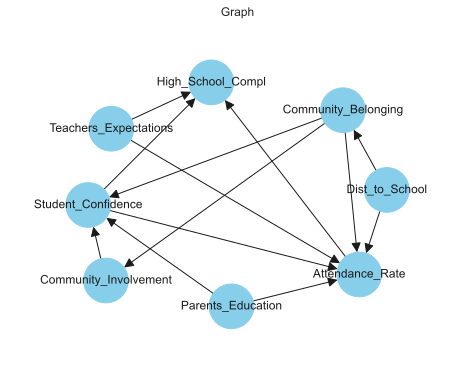

In [7]:
groundtruth = np.array([[0,0,0,1,0,0,1,0], # Distance
                        [0,0,0,0,0,1,1,0], # Parents Education
                        [0,0,0,0,0,0,1,1], # Teachers Expectations
                        [0,0,0,0,1,1,1,0], # Community Belonging
                        [0,0,0,0,0,1,0,0], # Community Involvement
                        [0,0,0,0,0,0,1,1], # Student Confidence
                        [0,0,0,0,0,0,0,1], # Attendance Rate
                        [0,0,0,0,0,0,0,0]]) # High School Completion


labels = {0: 'Dist_to_School', 1: 'Parents_Education', 2: 'Teachers_Expectations', 3 : 'Community_Belonging', 4 : 'Community_Involvement', 5 : 'Student_Confidence', 6 : 'Attendance_Rate', 7 : 'High_School_Compl'}
G_adj =  nx.from_numpy_array(groundtruth,  create_using=nx.DiGraph)
G_groundtruth = nx.relabel_nodes(G_adj, labels)
plot_graph( G_groundtruth )


In [10]:
res, params = compute_log_marginal_likelihood( data, G_groundtruth )

In [11]:
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression


# Prepare predictors and target variable
X = data.drop("High_School_Compl", axis=1)
y = data["High_School_Compl"]


# Add a constant to the predictors (for the intercept)
X_const = sm.add_constant(X)

# Fit the regression model
model = sm.OLS(y, X_const).fit()

# Print the summary, which includes p-values
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:      High_School_Compl   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 7.284e+08
Date:                Mon, 18 Sep 2023   Prob (F-statistic):               0.00
Time:                        13:04:50   Log-Likelihood:                 1601.5
No. Observations:                 500   AIC:                            -3187.
Df Residuals:                     492   BIC:                            -3153.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     1.00

In [23]:
# compute the corralation matrix for data
corr = data.corr()
corr.style.background_gradient(cmap='coolwarm')


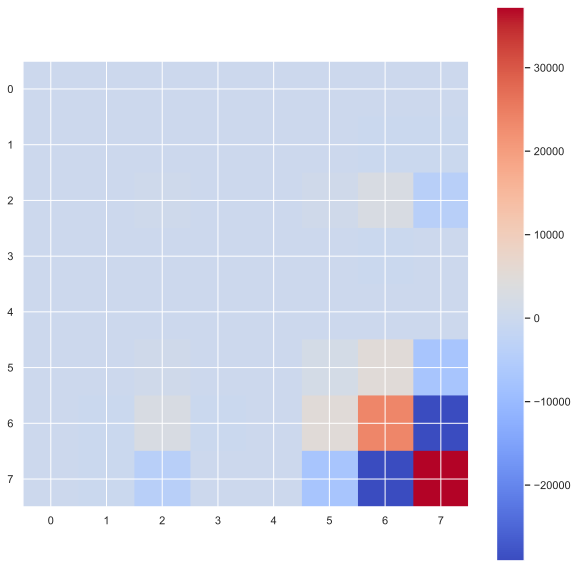

In [24]:
# inverse of the correlation matrix
corr_inv = np.linalg.inv(corr)

# plot the inverse of the correlation matrix
plt.figure(figsize=(10, 10))
plt.imshow(corr_inv, cmap='coolwarm')
plt.colorbar()  
plt.show()

In [13]:
# compute theoretical marginal likelihood: for each model, compute the marginal likelihood of the data, and then normalize across all DAGs
#all_dags, total_score = generate_all_dags( data )

#print( "total score: ", total_score )

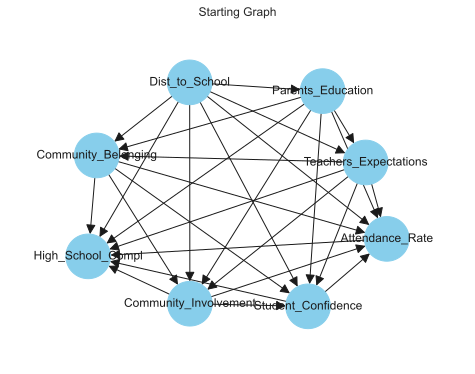

In [13]:
DATA = data

# create a dense directed acyclic graph
initial_graph = nx.DiGraph()
initial_graph.add_nodes_from(DATA.columns)
for i in range(0, len(DATA.columns)):
    for j in range(i+1, len(DATA.columns)):
        initial_graph.add_edge(DATA.columns[i], DATA.columns[j])
        
plot_graph(initial_graph, "Starting Graph")

In [19]:
DATA

Dist_to_School  Parents_Education  Teachers_Expectations  \
0         -0.005903           0.036465              -0.133103   
1          0.109275          -0.182047               0.016152   
2          0.079635           0.065253               0.089244   
3          0.023181           0.068575               0.083583   
4          0.067305          -0.015440               0.017845   
..              ...                ...                    ...   
495       -0.009251          -0.066775               0.010768   
496       -0.133324           0.081954               0.107034   
497        0.008017          -0.044398               0.043349   
498       -0.091793          -0.044374              -0.050598   
499       -0.221976           0.161165               0.034679   

     Community_Belonging  Community_Involvement  Student_Confidence  \
0               0.390652               0.387543            0.803748   
1              -0.390144              -0.388346           -0.920966   
2              -1.276569              -1.273100           -2.514467   
3               0.429563               0.437385            0.927488   
4               0.243966               0.243916            0.462859   
..                   ...                    ...                 ...   
495            -0.004456              -0.019616           -0.073840   
496            -0.125049              -0.141178           -0.196866   
497             0.467291               0.465073            0.904612   
498             0.384433               0.386956            0.722252   
499            -2.063343              -2.061328           -4.008063   

     Attendance_Rate  High_School_Compl  
0           1.787550          12.885306  
1          -2.297257         -14.131814  
2          -5.779948         -37.775979  
3           2.314207          16.448544  
4           1.081320           8.302583  
..               ...                ...  
495        -0.210568          -0.324103  
496        -0.272830          -0.933929  
497         2.137249          15.383620  
498         1.618800          11.885546  
499        -9.252719         -61.253109  

[500 rows x 8 columns]

In [14]:
# create an empty graph for data
empty_graph = nx.DiGraph()
empty_graph.add_nodes_from(DATA.columns)

In [15]:
groundtruth = np.array([[0,0,0,1,0,0,1,0], # Distance
                        [0,0,0,0,0,1,1,0], # Parents Education
                        [0,0,0,0,0,0,1,1], # Teachers Expectations
                        [0,0,0,0,1,1,1,0], # Community Belonging
                        [0,0,1,0,0,1,0,0], # Community Involvement
                        [0,0,0,0,0,0,1,1], # Student Confidence
                        [0,0,0,0,0,0,0,1], # Attendance Rate
                        [0,0,0,0,0,0,0,0]]) # High School Completion
groundtruth

array([[0, 0, 0, 1, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 1, 1, 0],
       [0, 0, 0, 0, 0, 0, 1, 1],
       [0, 0, 0, 0, 1, 1, 1, 0],
       [0, 0, 1, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 1],
       [0, 0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 0, 0, 0]])

In [26]:
res, params = compute_log_marginal_likelihood( DATA, G_groundtruth )

In [27]:
res

9674.354469842125

In [29]:
sample_parameters(params)

{'Dist_to_School': {'beta': -0.0021011696277513517,
  'sigma2': 0.012674150652251004},
 'Parents_Education': {'beta': 0.009383128672000952,
  'sigma2': 0.011052961170688595},
 'Teachers_Expectations': {'beta': array([ 0.13381045, -0.03500755]),
  'sigma2': 0.012815894028488291},
 'Community_Belonging': {'beta': array([ 1.00001133, -0.49503792]),
  'sigma2': 0.0022860719929347468},
 'Community_Involvement': {'beta': array([1.10977657, 2.88926083]),
  'sigma2': 0.0032047192506576916},
 'Student_Confidence': {'beta': array([0.64893387, 0.80147198, 0.00523873, 0.33632559]),
  'sigma2': 0.0022009454549719227},
 'Attendance_Rate': {'beta': array([ 0.80381683, -0.1012081 ,  0.90399053,  0.97671942,  0.60707469,
          2.14485398]),
  'sigma2': 0.002874784251100933},
 'High_School_Compl': {'beta': array([1.27468636, 1.53526456, 2.54911781, 5.4608819 ]),
  'sigma2': 0.006055356465661897}}

In [18]:
G_groundtruth.nodes

NodeView(('Dist_to_School', 'Parents_Education', 'Teachers_Expectations', 'Community_Belonging', 'Community_Involvement', 'Student_Confidence', 'Attendance_Rate', 'High_School_Compl'))

In [20]:
NUM_ITERATIONS = 10000
INITIAL_GRAPH = empty_graph

print("Starting MCMC...")

forbiddenArc_list = [ ("Teachers_Expectations", "Parents_Education"), ("Dist_to_School", "Teachers_Expectations") ]
for node in empty_graph.nodes():
    forbiddenArc_list.append( ("High_School_Compl", node) )
print("Forbidden Arcs:")
print(forbiddenArc_list)

posteriors, graph_candidates, Gs, graphs, marginals, operations, my_hash, params = structured_MCMC(DATA, INITIAL_GRAPH, forbiddenArc_list, NUM_ITERATIONS, score_function = "Log_Marginal_Likelihood", random_restarts = False, prob_restart = True, restart_freq = 100, jump_prob = 0.05)
print("Finished MCMC")

print()
print("Average Log Marginal Likelihood: ", np.mean(posteriors["marginal_likelihood"]))
print("Acceptance rate: ", posteriors['acceptance_rate'])


Starting MCMC...
Forbidden Arcs:
[('Teachers_Expectations', 'Parents_Education'), ('Dist_to_School', 'Teachers_Expectations'), ('High_School_Compl', 'Dist_to_School'), ('High_School_Compl', 'Parents_Education'), ('High_School_Compl', 'Teachers_Expectations'), ('High_School_Compl', 'Community_Belonging'), ('High_School_Compl', 'Community_Involvement'), ('High_School_Compl', 'Student_Confidence'), ('High_School_Compl', 'Attendance_Rate'), ('High_School_Compl', 'High_School_Compl')]
Jumped 486 times
Finished MCMC

Average Log Marginal Likelihood:  1320.9392763976812
Acceptance rate:  0.4508


In [981]:
forbiddenArc_list

[('Teachers_Expectations', 'Parents_Education'),
 ('Dist_to_School', 'Teachers_Expectations'),
 ('High_School_Compl', 'Dist_to_School'),
 ('High_School_Compl', 'Parents_Education'),
 ('High_School_Compl', 'Teachers_Expectations'),
 ('High_School_Compl', 'Community_Belonging'),
 ('High_School_Compl', 'Community_Involvement'),
 ('High_School_Compl', 'Student_Confidence'),
 ('High_School_Compl', 'Attendance_Rate'),
 ('High_School_Compl', 'High_School_Compl')]

In [17]:
# burnit
BURNIT = 5000
posteriors['marginal_likelihood'] = posteriors['marginal_likelihood'][BURNIT:]

graph_candidates = graph_candidates[BURNIT:]
np.mean(posteriors['marginal_likelihood'])

2617.4467810910155

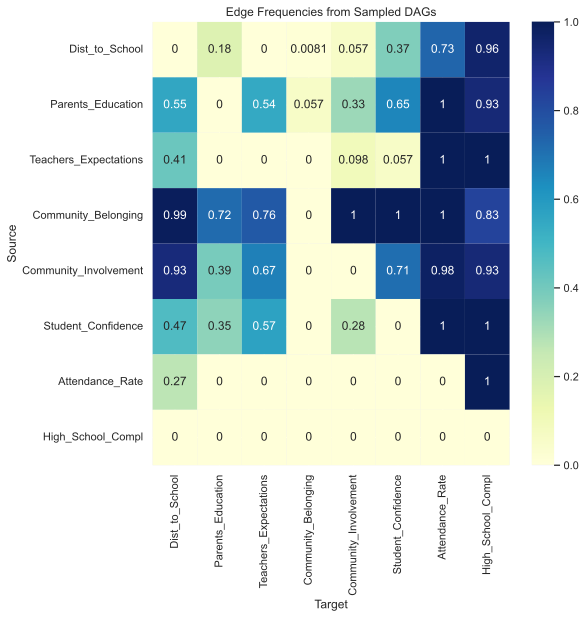

In [983]:
mcmc_edge_frequency_heatmap( list(graphs.values()) )

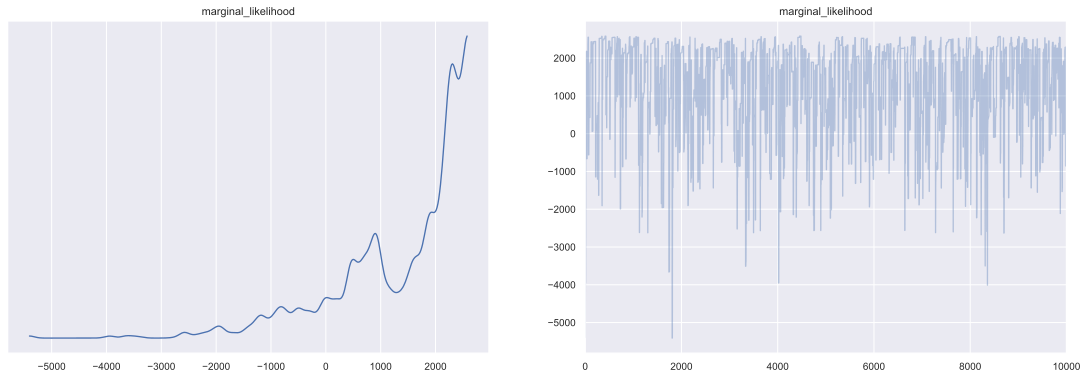

In [21]:
az.plot_trace(posteriors, var_names=["marginal_likelihood"], figsize=(19, 6));

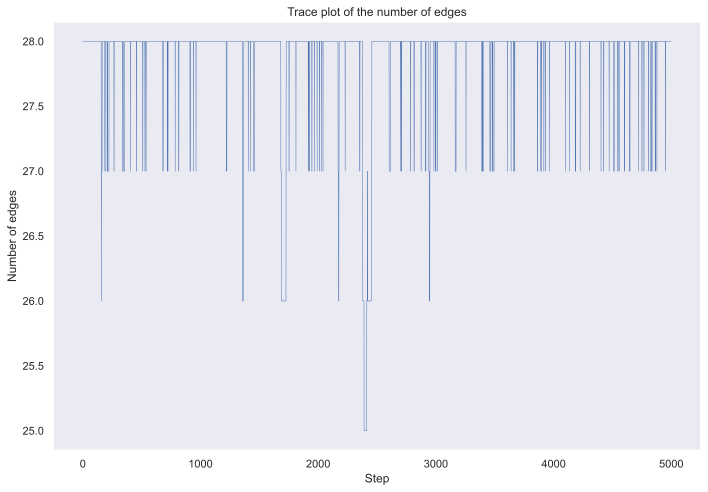

In [985]:

plot_edges_trace( graph_candidates, figsize=(10, 7))

In [986]:
len(Gs)

123

In [22]:
max_labels, max_freq = plot_graph_distribution( normalise_Gs(Gs) );

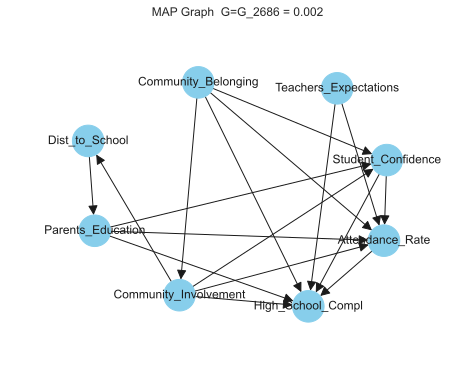

In [24]:
for label in max_labels:
    plot_graph( graphs[label], f"MAP Graph  G={label} = {np.round(max_freq,4)}", node_size = 1000)

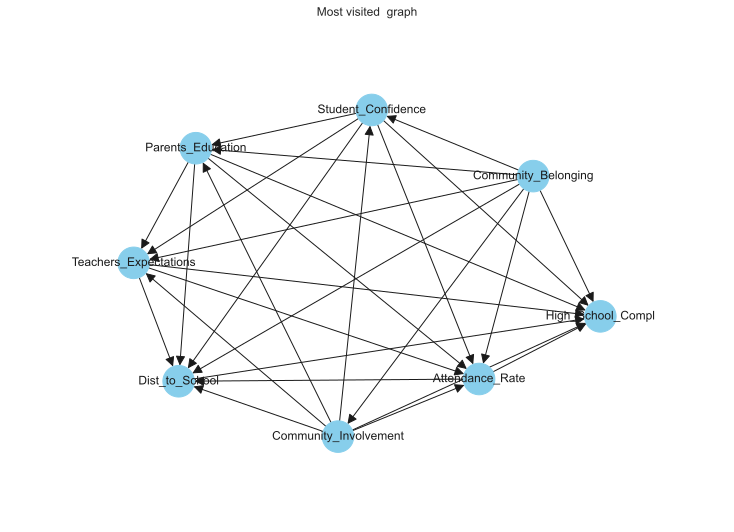

In [989]:
# increase the size of the figure
plt.figure(figsize=(10, 7))


plot_graph( graphs[label], "Most visited  graph", node_size = 1000, k = 5)

In [990]:
import networkx as nx
import requests
import json


# Convert to Cytoscape JSON format
cyto_data = nx.cytoscape_data(graphs[label])

# Send to Cytoscape (make sure Cytoscape is open with cyREST installed and running)
response = requests.post("http://localhost:1234/v1/networks?collection=My%20Collection", data=json.dumps(cyto_data))
print(response.json())

ConnectionError: HTTPConnectionPool(host='localhost', port=1234): Max retries exceeded with url: /v1/networks?collection=My%20Collection (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x2f63cad10>: Failed to establish a new connection: [Errno 61] Connection refused'))

In [ ]:

# plot_graph( graph_candidates[max_indx], f"Maximum Marginal Log Likelihood G = {graph_ID} : {posteriors['marginal_likelihood'][max_indx]}" )
adj_matrix_sparse = nx.adjacency_matrix( graphs[label] )
adj_matrix_dense = adj_matrix_sparse.todense()

# If you want it as a NumPy array:
adj_matrix_array = np.array(adj_matrix_dense)
adj_matrix_array

array([[0, 0, 0, 0, 0, 0, 0, 1],
       [1, 0, 1, 0, 0, 0, 1, 1],
       [1, 0, 0, 0, 0, 0, 1, 1],
       [1, 1, 1, 0, 1, 1, 1, 1],
       [1, 1, 1, 0, 0, 1, 1, 1],
       [1, 1, 1, 0, 0, 0, 1, 1],
       [1, 0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 0, 0, 0]])

<Axes: >

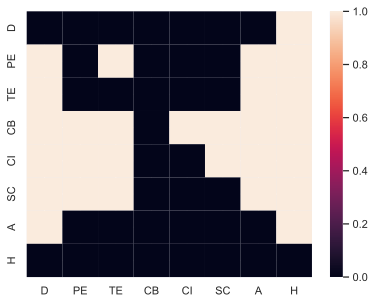

In [ ]:
sns.heatmap(adj_matrix_array , xticklabels=["D", "PE", "TE", "CB", "CI", "SC", "A", "H"], yticklabels=["D", "PE", "TE", "CB", "CI", "SC", "A", "H"])


<Axes: >

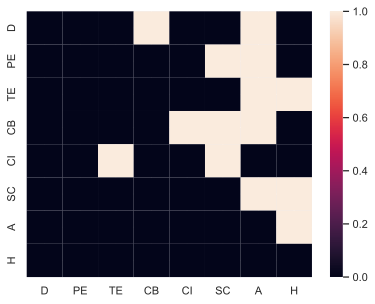

In [ ]:
sns.heatmap(groundtruth , xticklabels=["D", "PE", "TE", "CB", "CI", "SC", "A", "H"], yticklabels=["D", "PE", "TE", "CB", "CI", "SC", "A", "H"])


<Axes: >

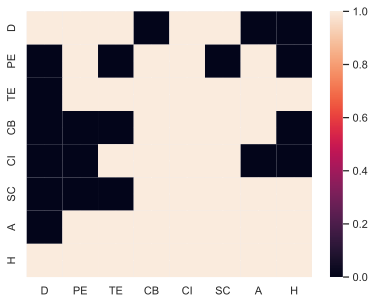

In [ ]:
sns.heatmap(adj_matrix_array == groundtruth, xticklabels=["D", "PE", "TE", "CB", "CI", "SC", "A", "H"], yticklabels=["D", "PE", "TE", "CB", "CI", "SC", "A", "H"])


In [945]:
# find the max of  posteriors['marginal_likelihood'] and return its index
max_indx = np.argmax( posteriors['marginal_likelihood'] )
graph_ID = my_hash[ graph_hash( graph_candidates[max_indx] ) ]

# plot_graph( graph_candidates[max_indx], f"Maximum Marginal Log Likelihood G = {graph_ID} : {posteriors['marginal_likelihood'][max_indx]}" )
adj_matrix_sparse_map = nx.adjacency_matrix(graphs[graph_ID])
adj_matrix_dense_map = adj_matrix_sparse.todense()

# If you want it as a NumPy array:
adj_matrix_array_map = np.array(adj_matrix_dense_map)
adj_matrix_array_map

array([[0, 1, 0, 0, 1, 1, 1, 1],
       [0, 0, 0, 0, 0, 0, 1, 1],
       [1, 0, 0, 0, 1, 1, 1, 1],
       [1, 1, 1, 0, 1, 1, 1, 1],
       [0, 1, 0, 0, 0, 1, 1, 1],
       [0, 1, 0, 0, 0, 0, 1, 1],
       [0, 0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 0, 0, 0]])

In [946]:
graphs[graph_ID]

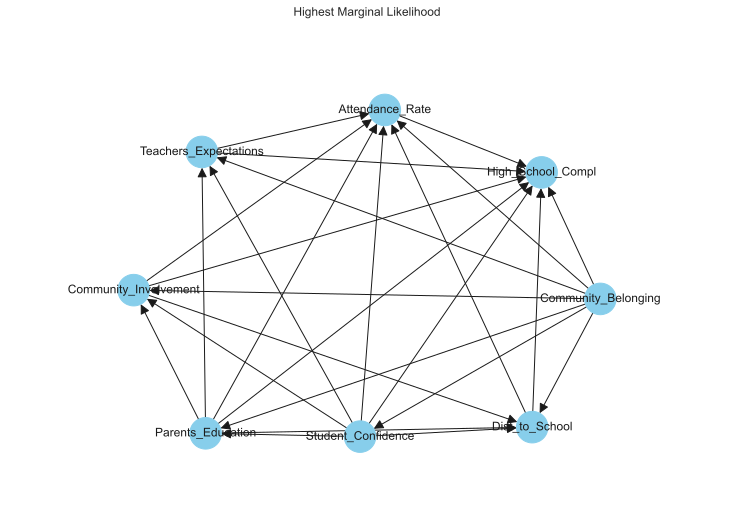

In [947]:
plt.figure(figsize=(10, 7))

plot_graph( graphs[graph_ID], "Highest Marginal Likelihood", node_size = 1000, k = 5)

In [948]:
adj_matrix_array_map

array([[0, 1, 0, 0, 1, 1, 1, 1],
       [0, 0, 0, 0, 0, 0, 1, 1],
       [1, 0, 0, 0, 1, 1, 1, 1],
       [1, 1, 1, 0, 1, 1, 1, 1],
       [0, 1, 0, 0, 0, 1, 1, 1],
       [0, 1, 0, 0, 0, 0, 1, 1],
       [0, 0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 0, 0, 0]])

<Axes: >

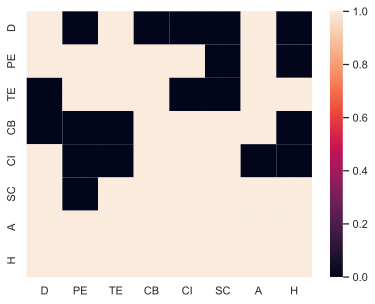

In [949]:
sns.heatmap(adj_matrix_array_map == groundtruth, xticklabels=["D", "PE", "TE", "CB", "CI", "SC", "A", "H"], yticklabels=["D", "PE", "TE", "CB", "CI", "SC", "A", "H"])


In [638]:
def mcmc_edge_frequency_heatmap(dags : list, figsize= (8,8)):
    
    nodes = list( dags[0].nodes())
    
    num_nodes = len(nodes)
    frequency_matrix = np.zeros((num_nodes, num_nodes))
    
    for G in dags:
        for edge in G.edges():
            source, target = edge
            frequency_matrix[nodes.index(source), nodes.index(target)] += 1
    
    # Normalize by the number of samples to get frequencies
    frequency_matrix /= len(dags)
    
    # Visualize as heatmap
    plt.figure(figsize=figsize)
    sns.heatmap(frequency_matrix, annot=True, cmap="YlGnBu", xticklabels=nodes, yticklabels=nodes)
    # add a label to the yaxis
    plt.ylabel("Source")
    # add a label to the xaxis
    plt.xlabel("Target")
    plt.title("Edge Frequencies from Sampled DAGs")
    plt.show()
    

In [231]:

max_params

{'X1': {'Lambda_n': array([[201.        ,  -5.49777539, -28.25142266],
         [ -5.49777539, 208.71310488,   4.77277206],
         [-28.25142266,   4.77277206, 216.42569298]]),
  'm_n': array([ 0.99737106,  2.9823529 , -1.98624458]),
  'a_n': 101.0,
  'b_n': 8.867328739775985},
 'X2': {'Lambda_n': array([[201.]]),
  'm_n': array([-0.02735212]),
  'a_n': 101.0,
  'b_n': 104.78136454223298},
 'X3': {'Lambda_n': array([[201.]]),
  'm_n': array([-0.14055434]),
  'a_n': 101.0,
  'b_n': 106.72741643276974}}

In [232]:
max_score

-635.4065427882942

{'X1': {'beta': array([1.58086142, 3.10810952]), 'sigma2': 4.49415589757693},
 'X2': {'beta': 0.06448170411524515, 'sigma2': 1.0656882696096888},
 'X3': {'beta': -0.14112955119549667, 'sigma2': 0.9889496081494852}}

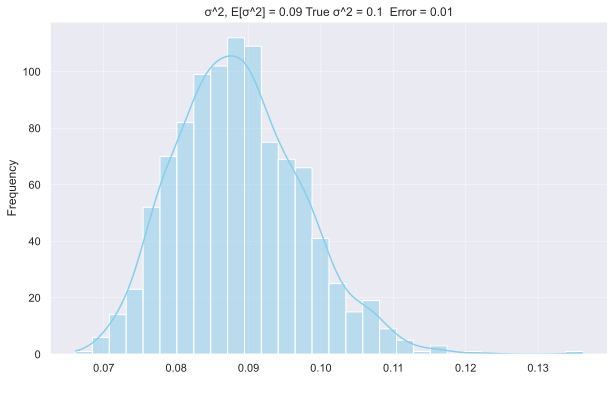

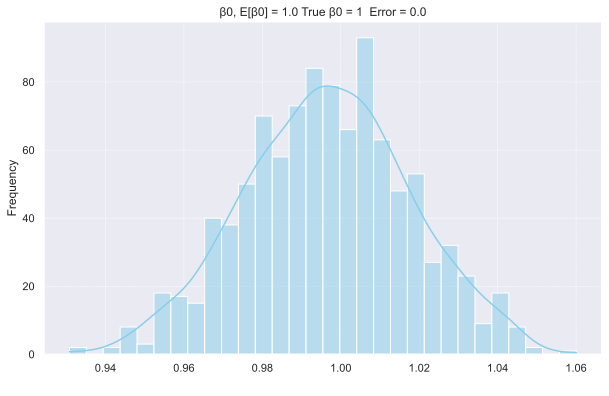

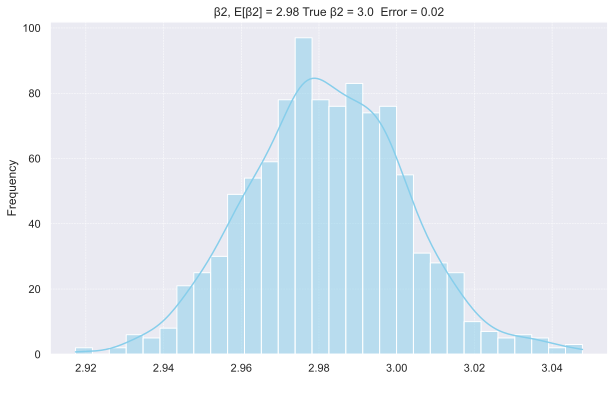

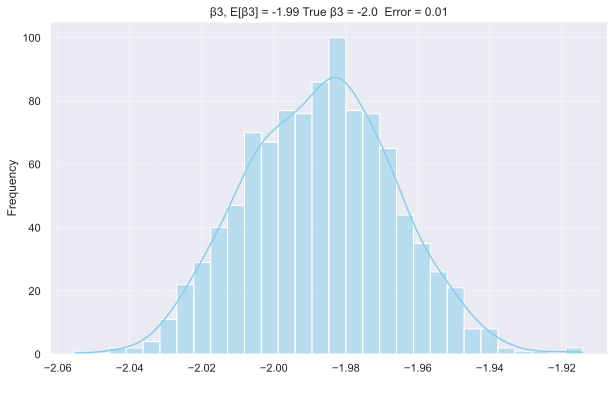

In [233]:
# make a density map of the sample parameters
num_samples = 1000

outputs = []
sigmas2 = []
beta0s = []
beta2s = []
beta3s = []

max_score, max_params = compute_log_marginal_likelihood(DATA, graph_candidates[max_indx])

for i in range(num_samples):
    sampled_params = sample_parameters( max_params )
    
    # get params for X1 (our regression node)
    sigmas2.append( sampled_params["X1"]["sigma2"] )
    
    # get regression coefficients
    beta0s.append( sampled_params["X1"]["beta"][0] )
    beta2s.append( sampled_params["X1"]["beta"][1] )
    beta3s.append( sampled_params["X1"]["beta"][2] )
    
error_sigma2 = np.round( np.abs(gen_data_params['sigma_epsilon'] - np.mean(sigmas2) ), 2)
plot_histogram(sigmas2, title = f"σ^2, E[σ^2] = {np.round(np.mean(sigmas2),2)} True σ^2 = {gen_data_params['sigma_epsilon']}  Error = {error_sigma2}", xlabel=" ")

error_beta0 = np.round( np.abs(gen_data_params['beta0'] - np.mean(beta0s) ), 2)
plot_histogram(beta0s, title = f"β0, E[β0] = {np.round(np.mean(beta0s),2)} True β0 = {gen_data_params['beta0']}  Error = {error_beta0}", xlabel=" ")

error_beta2 = np.round( np.abs(gen_data_params['beta2'] - np.mean(beta2s) ), 2)
plot_histogram(beta2s, title = f"β2, E[β2] = {np.round(np.mean(beta2s),2)} True β2 = {gen_data_params['beta2']}  Error = {error_beta2}", xlabel=" ")

error_beta3 = np.round( np.abs(gen_data_params['beta3'] - np.mean(beta3s) ), 2)
plot_histogram(beta3s, title = f"β3, E[β3] = {np.round(np.mean(beta3s),2)} True β3 = {gen_data_params['beta3']}  Error = {error_beta3}", xlabel=" ")


### Debugging

In [299]:
params[]

{'G_0': {'X1': {'Lambda_n': array([[201.]]),
   'm_n': array([0.98324408]),
   'a_n': 101.0,
   'b_n': 67.90146078309766},
  'X2': {'Lambda_n': array([[201.]]),
   'm_n': array([0.07818556]),
   'a_n': 101.0,
   'b_n': 124.85337771219696},
  'X3': {'Lambda_n': array([[201.        , 197.6320609 ],
          [197.6320609 , 329.12347627]]),
   'm_n': array([-0.91269099,  0.85384668]),
   'a_n': 101.0,
   'b_n': 45.49899472793677}},
 'G_1': {'X1': {'Lambda_n': array([[201.        , -14.70340945],
          [-14.70340945, 189.35219328]]),
   'm_n': array([1.02796439, 0.61133999]),
   'a_n': 101.0,
   'b_n': 32.71853016066768},
  'X2': {'Lambda_n': array([[201.]]),
   'm_n': array([0.07818556]),
   'a_n': 101.0,
   'b_n': 124.85337771219696},
  'X3': {'Lambda_n': array([[201.]]),
   'm_n': array([-0.07315129]),
   'a_n': 101.0,
   'b_n': 94.63830995110126}},
 'G_2': {'X1': {'Lambda_n': array([[201.        , -14.70340945],
          [-14.70340945, 189.35219328]]),
   'm_n': array([1.02796439,

In [ ]:
sample_parameters(parameters)

In [273]:
graphs

{'G_0': <networkx.classes.digraph.DiGraph at 0x2c2ca7750>,
 'G_1': <networkx.classes.digraph.DiGraph at 0x2c2aa0790>,
 'G_2': <networkx.classes.digraph.DiGraph at 0x2c2ee1f50>}

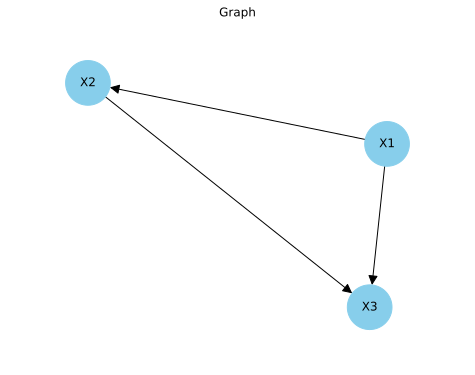

In [274]:
G_current = graphs["G_0"]
plot_graph( G_current )

add_edge


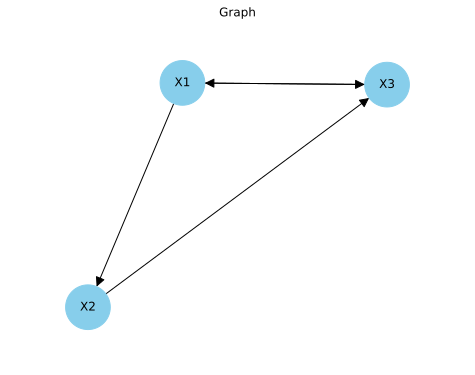

In [275]:
G_proposed, operation = propose_new_graph(G_current)
print(operation)
plot_graph(G_proposed)

delete_edge


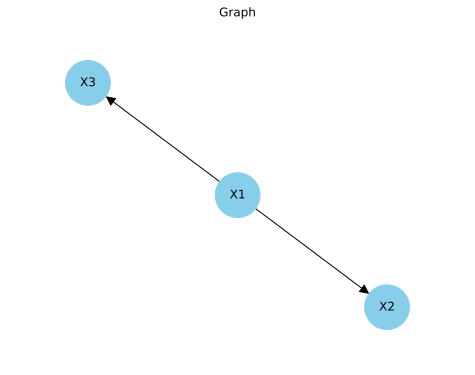

In [276]:
G_proposed, operation = propose_new_graph(G_current)
print(operation)
plot_graph(G_proposed)

In [ ]:
# Example usage:
# G1 = nx.DiGraph([('X2', 'X1'), ('X3', 'X1')])
# G2 = nx.DiGraph([('X1', 'X2'), ('X3', 'X1')])
# plot_graph_transition(G1, G2)

graph_t0 = graph_candidates[0]
plot_graph(graph_t0, "Graph G_0")

for i in range(1, 10):
    graph_t1 = graph_candidates[i]
    operation = operations[i]
    print("Operation: ", operation)
    g_out = plot_graph_transition(graph_t0, graph_t1, i)
    graph_t0 = graph_t1
    plot_graph(graph_t1, f"Graph G_{i}")
    print(graph_t1.adj)
    

## BIC Score Example

In [266]:

# start with all nodes independet from each other
# initial_graph = nx.DiGraph()
# initial_graph.add_nodes_from(data.columns)

posteriors_bic, graph_candidates_bic, Gs_bic, graphs_bic, marginals_bic, operations_bic = structured_MCMC(DATA, initial_graph, NUM_ITERATIONS, score_function = "BIC", restart_freq=100)

TypeError: cannot unpack non-iterable numpy.float64 object

In [284]:
print(posteriors_bic['acceptance_rate'])

0.5


In [285]:
print(np.mean(posteriors_bic['marginal_likelihood']))

-12520.558602091613


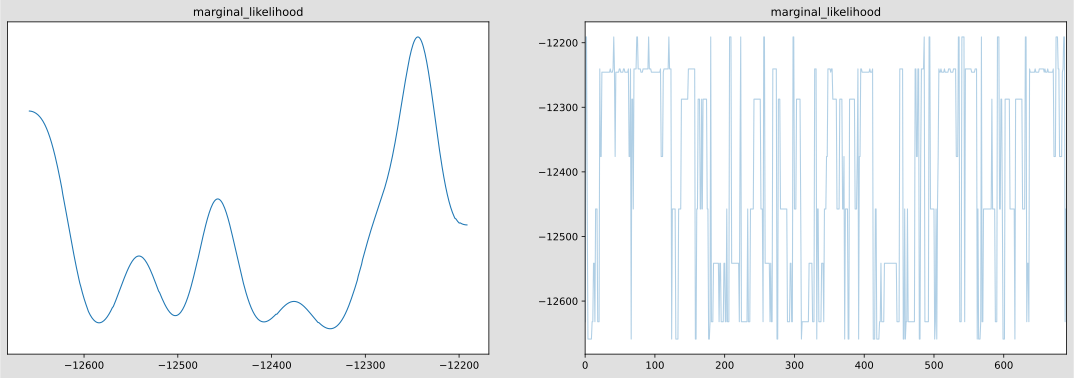

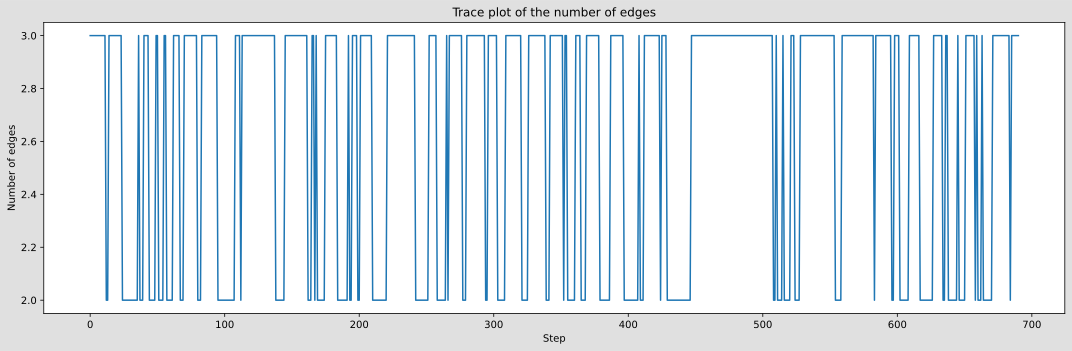

In [249]:
az.plot_trace(posteriors_bic, var_names=["marginal_likelihood"], figsize=(19, 6));
plot_edges_trace( graph_candidates_bic)

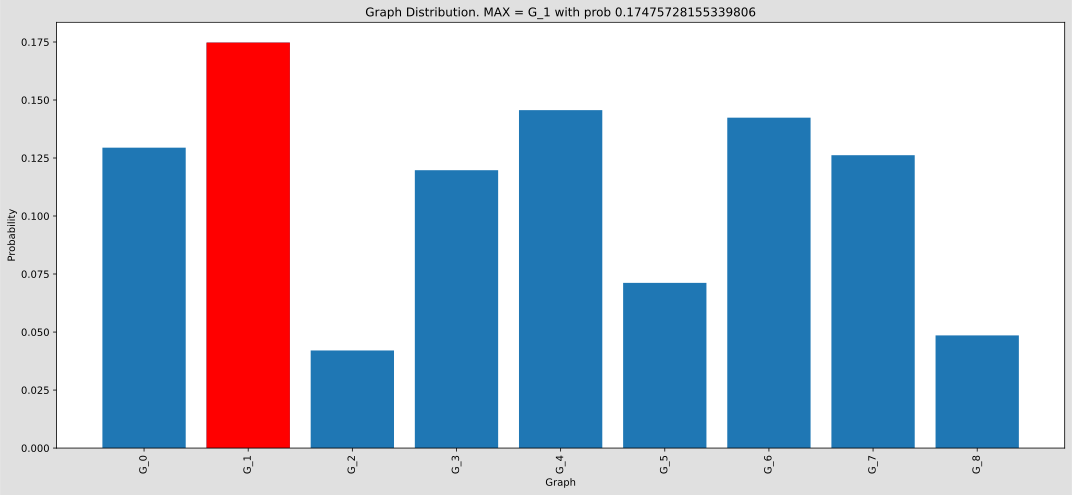

In [250]:
max_labels, max_freq = plot_graph_distribution( normalise_Gs(Gs_bic) )

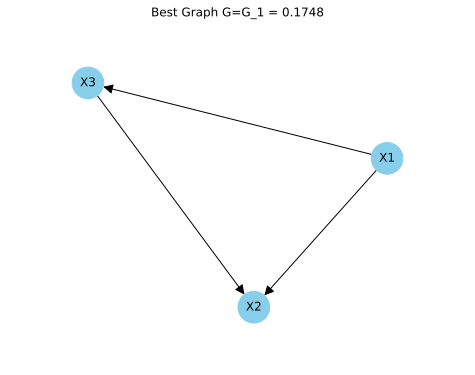

In [251]:
for label in max_labels:
    plot_graph( graphs_bic[label], f"Best Graph G={label} = {np.round(max_freq,4)}", node_size = 1000)

In [253]:

# start with all nodes independet from each other
# initial_graph = nx.DiGraph()
# initial_graph.add_nodes_from(data.columns)

posteriors_aic, graph_candidates_aic, Gs_aic, graphs_aic, marginals_aic, operations_aic = structured_MCMC(DATA, initial_graph, NUM_ITERATIONS, score_function = "AIC", restart_freq=100)

In [254]:
print(posteriors_aic['acceptance_rate'])


0.338


In [255]:
print(np.mean(posteriors_bic['marginal_likelihood']))

-12398.32783719744


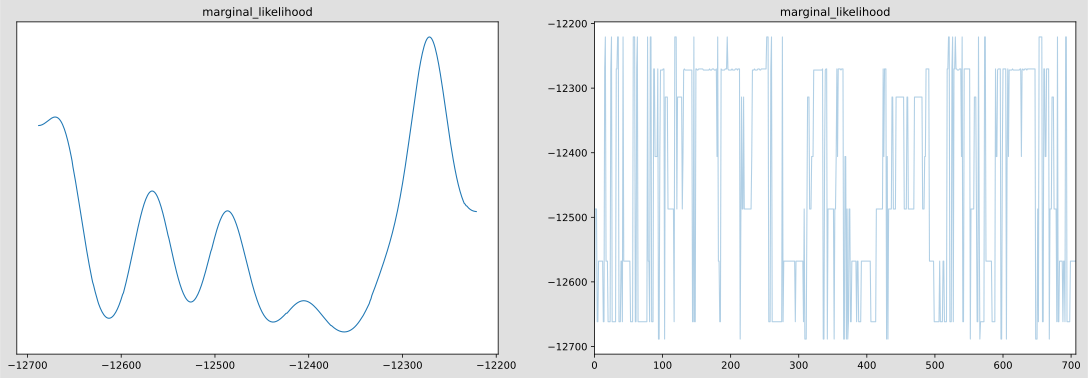

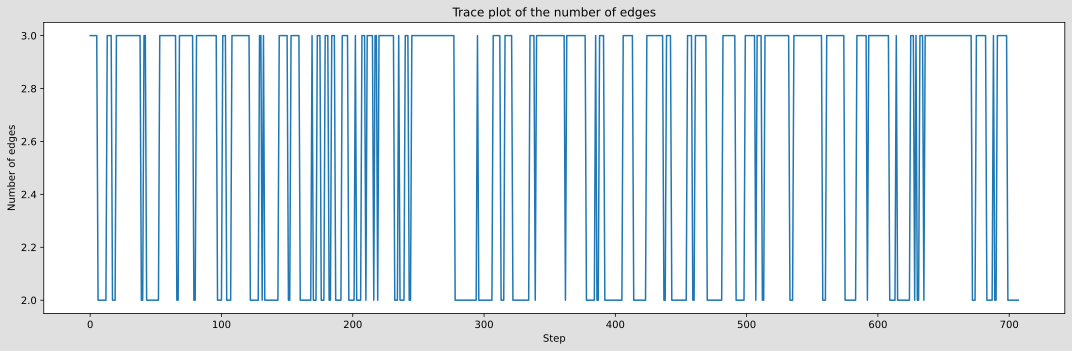

In [256]:
az.plot_trace(posteriors_aic, var_names=["marginal_likelihood"], figsize=(19, 6));
plot_edges_trace( graph_candidates_aic)

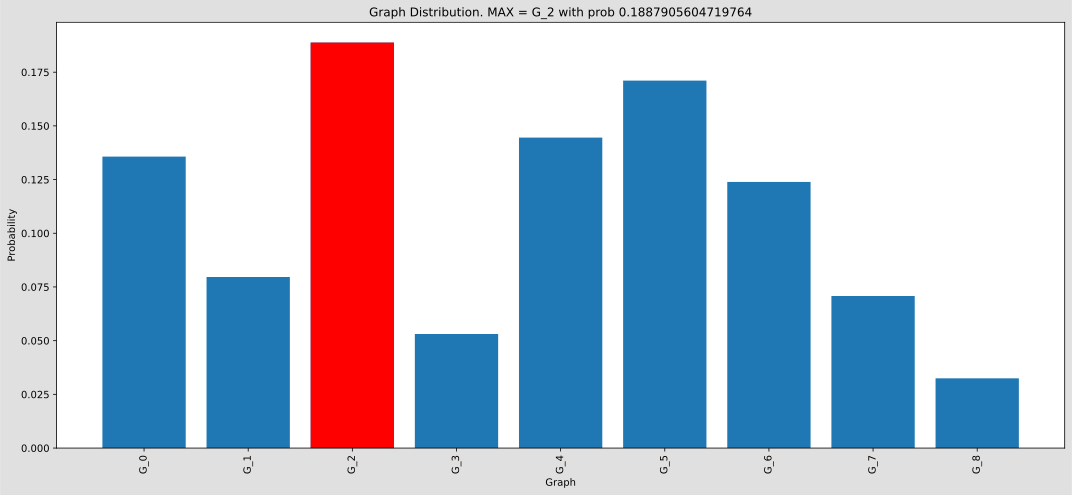

In [257]:
max_labels, max_freq = plot_graph_distribution( normalise_Gs(Gs_aic) )

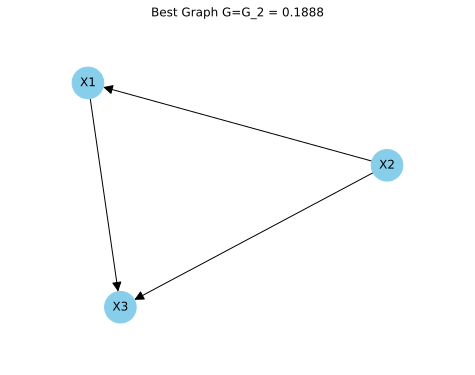

In [258]:
for label in max_labels:
    plot_graph( graphs_aic[label], f"Best Graph G={label} = {np.round(max_freq,4)}", node_size = 1000)

In [4]:
from math import comb

def number_of_dags(n, memo={}):
    # Base cases
    if n == 0:
        return 1
    if n == 1:
        return 1

    # If value is already computed, return it
    if n in memo:
        return memo[n]
    
    # Recursive computation based on the corrected formula
    total = 0
    for k in range(1, n+1):
        total += (-1)**(k + 1) * comb(n, k) * (2 ** (k * (n - k))) * number_of_dags(n - k, memo)
        
    # Store the computed value in memo and return
    memo[n] = total
    return total

# Test the function
print(number_of_dags(3))  # Should output 25


25
